In [618]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import quandl
import sys
import scipy.optimize as scoplt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

plt.style.use('fivethirtyeight')
np.random.seed(777)

data = yf.download(['BTC-USD','ETH-USD','XRP-USD','LINK-USD'],start="2019-01-01",end="2021-01-01")
#data = yf.download(['AAPL','NKE','GOOGL','AMZN'],start="2018-01-01",end="2021-01-01")

daily_returns = data
data = data['Adj Close']
data

[*********************100%***********************]  4 of 4 completed


,BTC-USD,ETH-USD,LINK-USD,XRP-USD
Date,,,,
2019-01-01,3843.520020,140.819412,0.299371,0.364771
2019-01-02,3943.409424,155.047684,0.316489,0.375243
2019-01-03,3836.741211,149.135010,0.365974,0.360224
2019-01-04,3857.717529,154.581940,0.437175,0.356747
2019-01-05,3845.194580,155.638596,0.395948,0.355275
...,...,...,...,...
2020-12-28,27084.808594,730.397339,12.628381,0.247958
2020-12-29,27362.437500,731.520142,11.771125,0.220962
2020-12-30,28840.953125,751.618958,11.253575,0.211828


In [616]:
# Calculate daily return. 
daily_returns = np.log(1+daily_returns['Adj Close'].pct_change())
daily_returns

,BTC-USD,ETH-USD,LINK-USD,XRP-USD
Date,,,,
2019-01-01,NaN,NaN,NaN,NaN
2019-01-02,0.025657,0.096254,0.055605,0.028304
2019-01-03,-0.027422,-0.038881,0.145274,-0.040848
2019-01-04,0.005452,0.035872,0.177771,-0.009699
2019-01-05,-0.003251,0.006812,-0.099051,-0.004135
...,...,...,...,...
2020-12-28,0.030458,0.067618,0.040289,-0.132325
2020-12-29,0.010198,0.001536,-0.070297,-0.115269
2020-12-30,0.052625,0.027105,-0.044964,-0.042216


In [ ]:
# remove first row (can't be calcualted).
daily_returns = daily_returns.drop(daily_returns.index[0])
daily_returns



In [ ]:

plt.figure(figsize=(14, 7))
for c in daily_returns.columns.values:
    plt.plot(daily_returns.index, daily_returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

In [ ]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [ ]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [ ]:
returns = daily_returns
mean_returns = returns.mean()
#mean_returns
cov_matrix = returns.cov()
corr_matrix = daily_returns.apply(lambda x: np.log(1+x)).corr()
#corr_matrix

ind_er = data.resample('Y').last().pct_change().mean()
#ind_er
ann_sd = daily_returns.apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
#ann_sd
mean_returns


In [ ]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

In [ ]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(daily_returns.columns)
num_portfolios = 20000
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)
    


In [ ]:
data2 = {'Returns':p_ret, 'Volatility':p_vol}
for counter, symbol in enumerate(daily_returns.columns.tolist()):
    #print(counter, symbol)
    data2[symbol+' weight'] = [w[counter] for w in p_weights]
    
portfolios  = pd.DataFrame(data2)

In [ ]:
portfolios.head() # Dataframe of the 10000 portfolios created

In [ ]:
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])

In [ ]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)

In [619]:
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port


Returns            2.354642
Volatility         0.732495
BTC-USD weight     0.088471
ETH-USD weight     0.676892
LINK-USD weight    0.234268
XRP-USD weight     0.000370
Name: 8245, dtype: float64

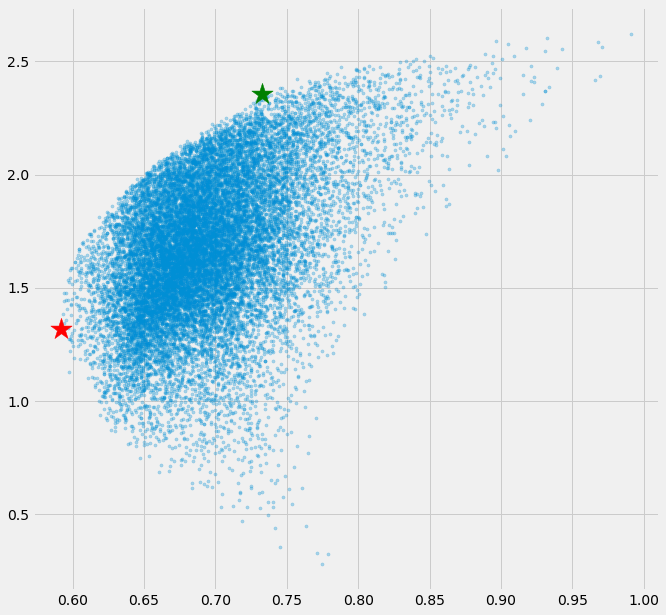

In [614]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)